In [46]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6
from collections import Counter

In [47]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    # initialise and raise input errors
    def __init__(self, n_arms):
        if not type(n_arms)==int:
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        
    @abstractmethod
    # raise input errors
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        if not type(context) == np.ndarray:
            raise TypeError("`context` must be numpy.ndarray")
        if not context.shape == (n_arms, n_dims):
            raise TypeError("`context` must have shape (n_arms, n_dims)")
        self.context = context

    
    @abstractmethod
    # raise input errors
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        if not (type(arm) == int or arm.dtype == 'int64'):
            raise TypeError("`arm` must be int type")
        if not (arm >= 0 and arm <= (n_arms-1)):
            raise ValueError("`arm` must be the the set {0, .., n_arms - 1}")
        if not (type(reward) == float or reward.dtype == 'float64'):
            raise TypeError("`reward` must be float type")
        if not (context.shape == (n_arms, n_dims) and context.dtype == 'float64') :
            raise TypeError("`context` must be float numpy in shape (n_events, n_arms, n_dims)")
        # get the values
        self.arm = arm
        self.reward = reward
        self.context = context



In [48]:
# Define global functions 
def break_tie(_range):
    indices = np.argwhere(_range == np.max(_range))
    index = np.random.randint(0,len(indices))

    return indices[index][0]

## Load dataset

In [49]:
# load dataset here

data = np.loadtxt("./smalltraindataset.txt")
arms, rewards, contexts = data[:,0], data[:,1], data[:,2:]
arms = arms.astype(np.int64)
rewards = rewards.astype(float)
contexts = contexts.astype(float)
n_arms = len(np.unique(arms))
n_events = len(contexts)
n_dims = int(len(contexts[0])/n_arms)
contexts = contexts.reshape(n_events, n_arms, n_dims)
datadist = np.array([Counter(arms)[x] for x in np.arange(20)])
    

## Off-policy evaluation

In [50]:
def gini(array):
    array = array + 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None, rewardtype = 0):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    # initialise values and raise input errors
    if not (arms.shape == (n_events,) and arms.dtype == 'int64')  :
        raise TypeError("`arms` must be integer numpy in shape (n_events,)")
    if not rewards.shape == (n_events,) and rewards.dtype == 'float64' :
        raise TypeError("`rewards` must be float numpy in shape (n_events,)")
    if not contexts.shape == (n_events, n_arms, n_dims) and rewards.dtype == 'float64' :
        raise TypeError("`contexts` must be float numpy in shape (n_events, n_arms, n_dims)")
    if n_rounds == None:        # set n_rounds to infinite number to run until all data exhausted
        n_rounds = np.inf
    elif not type(n_rounds) == int:
        raise TypeError("`n_rounds` must be integer or default 'None'")

    n_round = 0     # count the current round ; 0 indicates the first round
    R = []          # save the total payoff
    H = []          # save used historical events
    acc = np.zeros(n_events)
    # n_arms = 20
    dist = np.zeros(n_arms)
    prot = set([13, 14, 17, 18])
    psp = np.array([1,1])
    for i in range(n_events):
        if n_round == n_rounds:
            break
        arm = mab.play(contexts[i])
        if arm == arms[i]:                 # if historical data equals to chosen arm
            # R.append(rewards[i])           # append the new rewards
            dist[arm] += 1
            if arm in prot:
                psp[0] +=1
            else:
                psp[1] += 1
            pspscore = (psp[0]-psp[1])/(psp[0] + psp[1])
            
            H.append([arms[i], rewards[i], 1-gini(dist), pspscore])      # append the used events
            if rewardtype == 0:
                mab.update(arms[i], rewards[i], contexts[i])      # update the information
            elif rewardtype == 1:
                mab.update(arms[i], rewards[i]+1-gini(dist), contexts[i])      # gini reward
            else:
                mab.update(arms[i], rewards[i]+min(0, pspscore), contexts[i])      # update the information


            n_round += 1
            acc[i] = rewards[i]
        # else:
        #     H.append([arm, 0, gini(dist), (psp[0]-psp[1])/(psp[0] + psp[1])])      # append the used events


    # return rewards per play
    out = np.array(H)
        
    return out, dist, psp

## 1. ε-greedy MAB

In [51]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm
    
    # select a random arm to explore or a arm with best rewards to exploit, then return the arm 
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms) 
        else:
            arm = break_tie(self.q)
        return arm 
    
    # update values
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]
        

In [52]:
def evaluateMab(results, dist, psp):
    print(n_events, " total lines")
    print(results.shape[0], " matches")
    print(np.mean(results[:, 1]), " Average reward")
    print(np.mean(results[:, 2]), " Average Gini Index")
    print(np.mean(results[:, 3]), " Average PSP")
    
    fig, axs = plt.subplots(4,1, sharex=False, figsize=(20,20))
    axs[0].plot(results[:, 2])
    axs[0].title.set_text("Gini Index")
    axs[1].plot(results[:, 3])
    axs[1].title.set_text("PSP")
    axs[2].bar(np.arange(20), dist) 
    axs[2].title.set_text("Model distribution")
    axs[3].bar(np.arange(20), datadist) 
    axs[3].title.set_text("Dataset distribution")

    

In [53]:
mab = EpsGreedy(20, 0.05) 
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None)
print('EpsGreedy average reward', np.mean(results_EpsGreedy[:, 1]))

EpsGreedy average reward 0.9648013199505019


201632  total lines
9948  matches
0.5312625653397668  Average reward
0.705303174543274  Average Gini Index
-0.7677220152817772  Average PSP


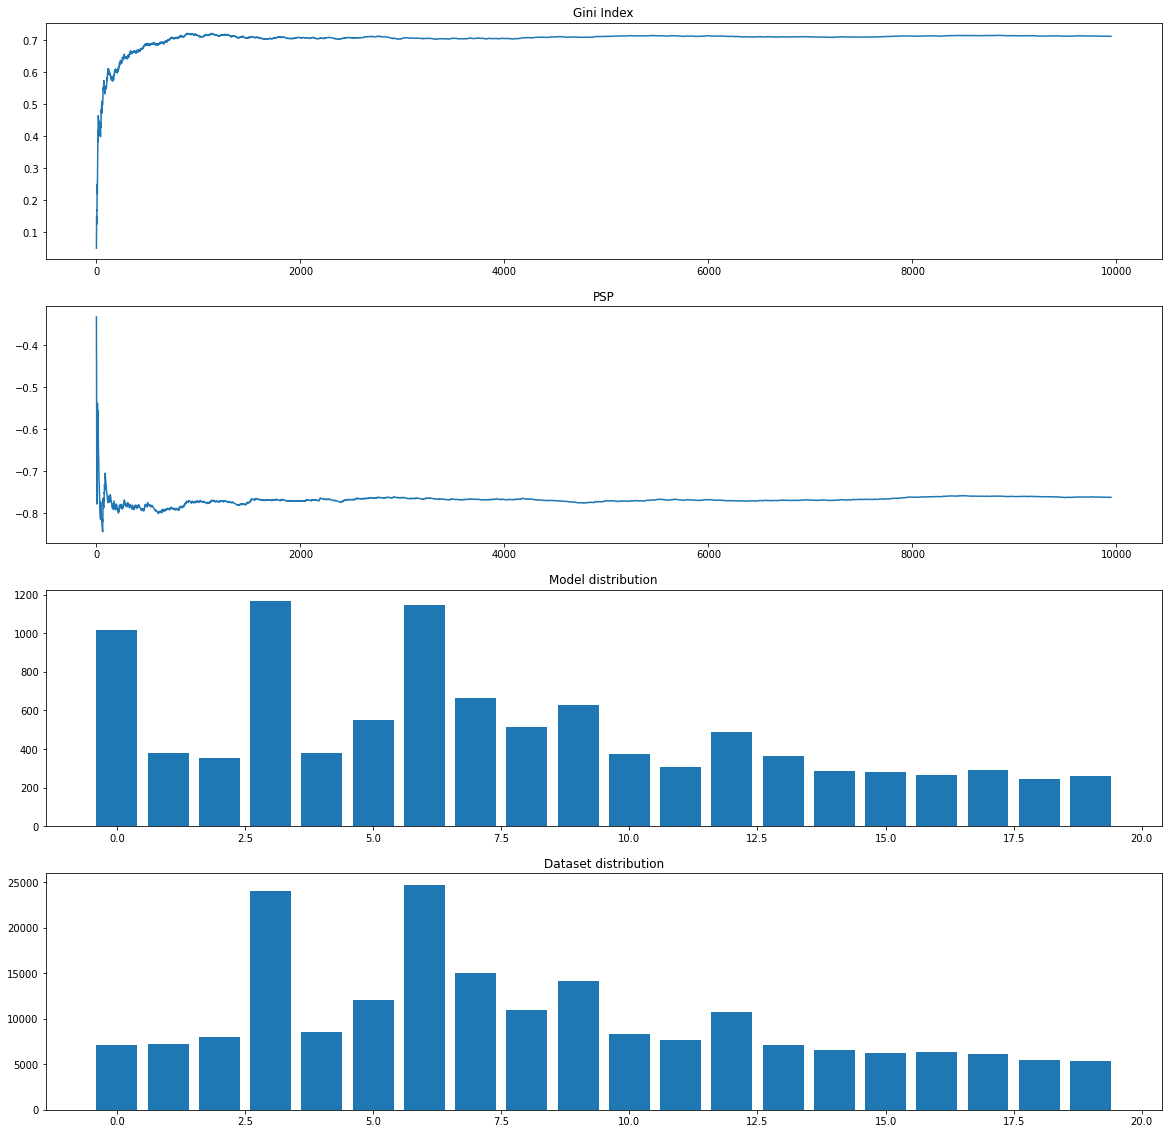

In [56]:
mab = EpsGreedy(20, 0.9) 
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 0)
evaluateMab(results_EpsGreedy, dist, psp)

201632  total lines
9854  matches
0.53521412624315  Average reward
0.7046744354031657  Average Gini Index
-0.778147896656004  Average PSP


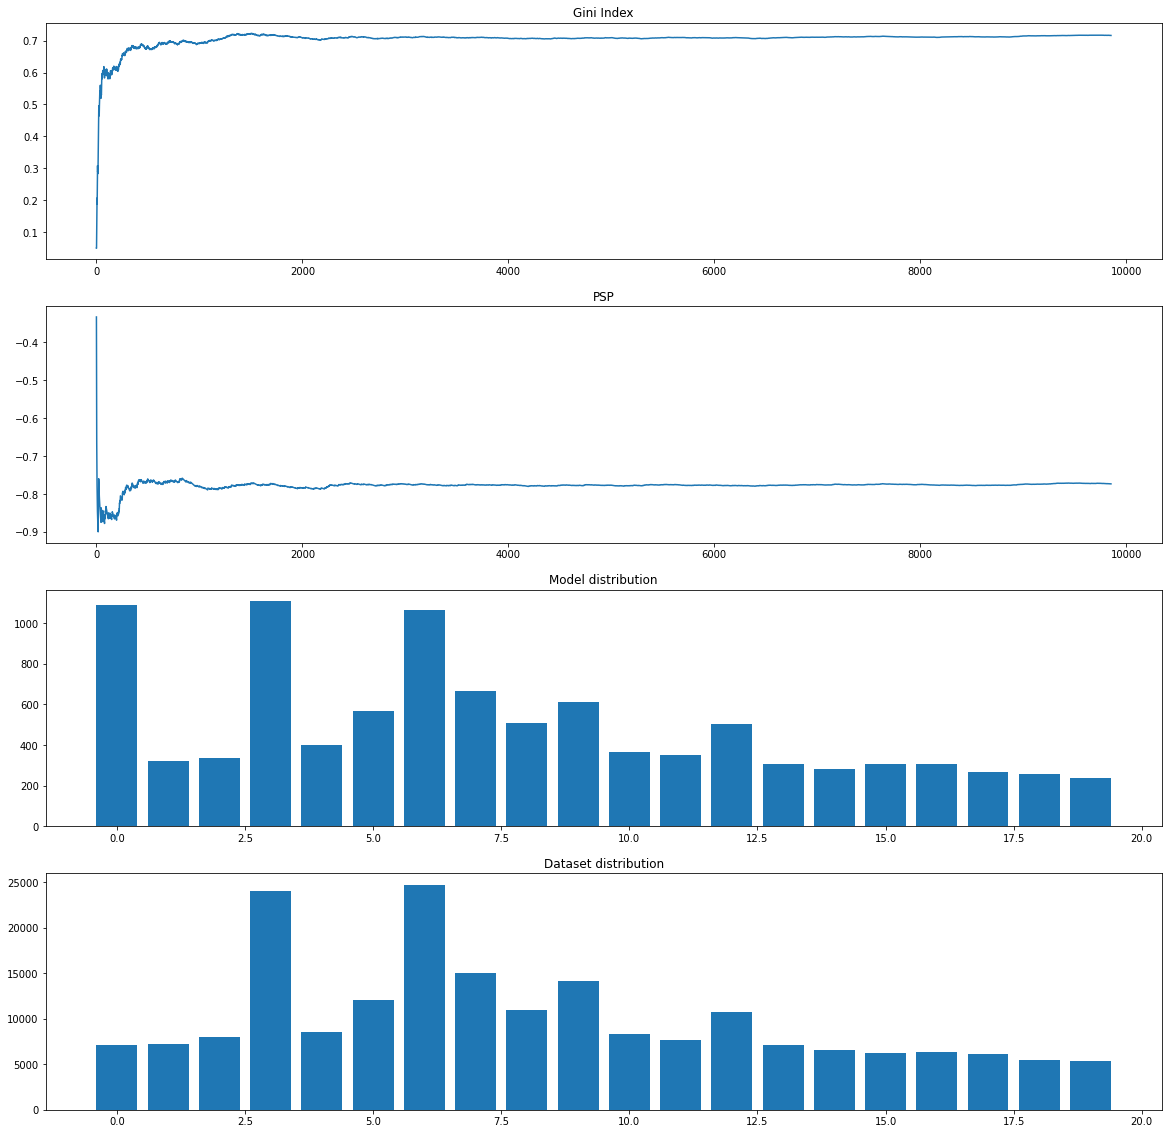

In [ ]:
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 0)
evaluateMab(results_EpsGreedy, dist, psp)

201632  total lines
9769  matches
0.5280990889548572  Average reward
0.7254989252014246  Average Gini Index
-0.7629051338234626  Average PSP


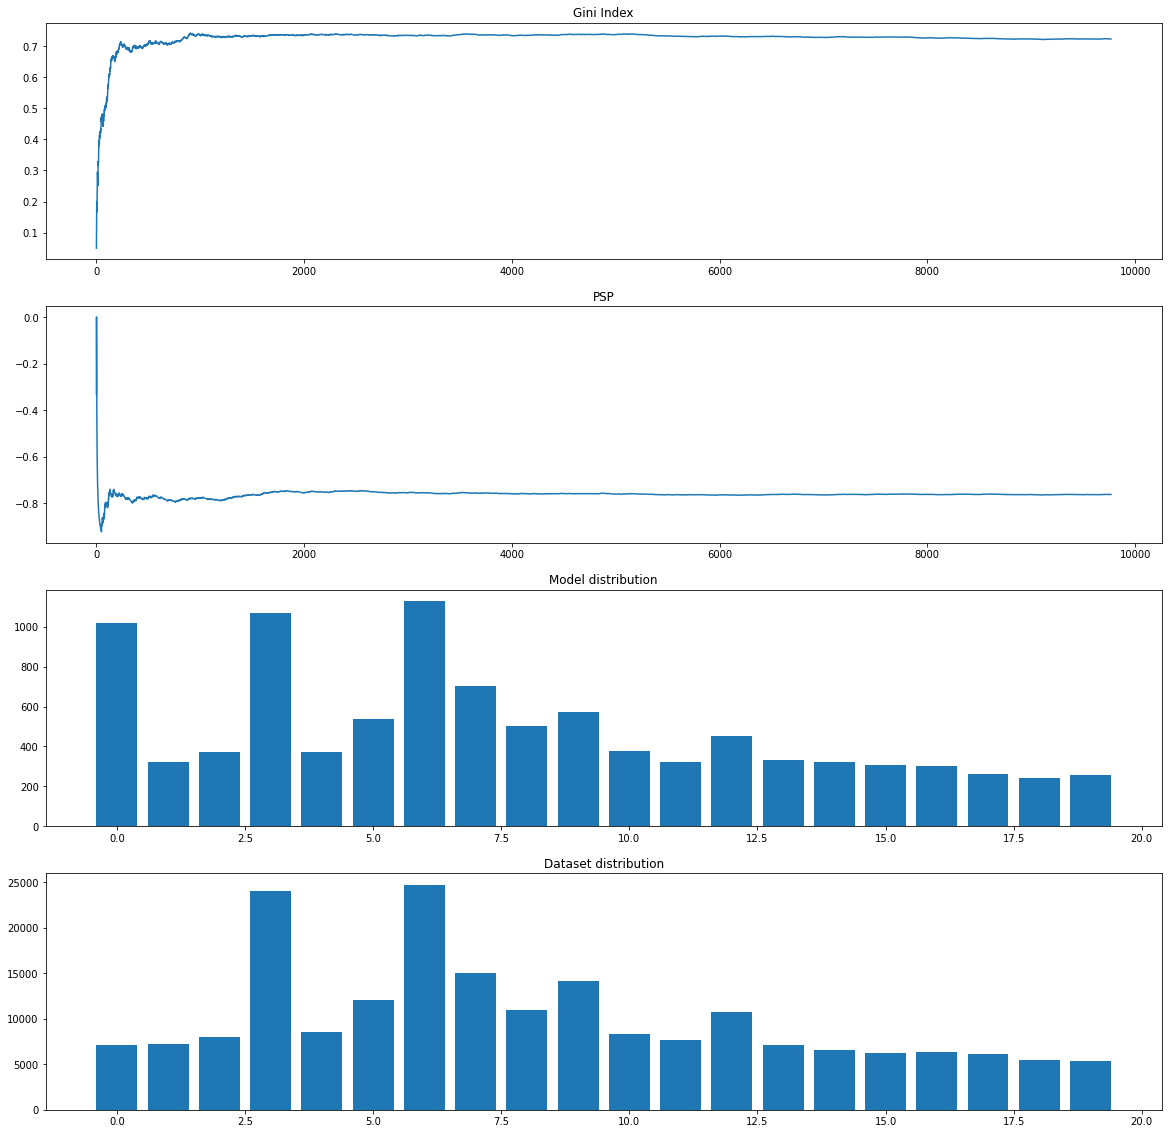

In [ ]:
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 1)
evaluateMab(results_EpsGreedy, dist, psp)

201632  total lines
9686  matches
0.5310757794755318  Average reward
0.7077096656897424  Average Gini Index
-0.7669365409350463  Average PSP


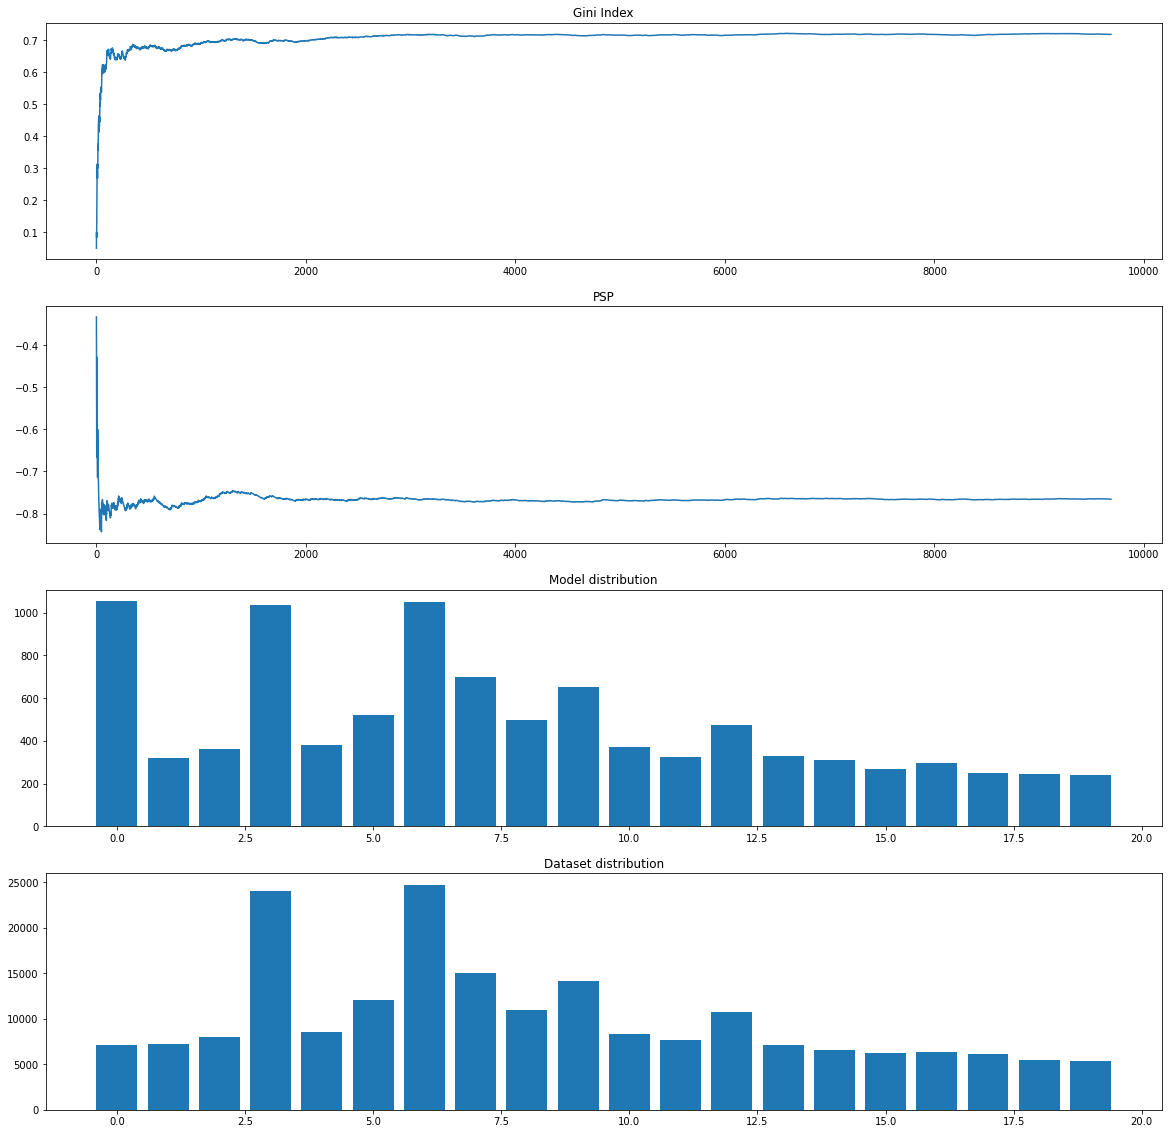

In [ ]:
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 2)
evaluateMab(results_EpsGreedy, dist, psp)

In [ ]:
class FairEpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm
        self.armtogenre = [13, 14, 17, 18]
        self.genretoarm = {13: 0, 14: 1, 17: 2, 18: 3}
    
    # select a random arm to explore or a arm with best rewards to exploit, then return the arm 
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms) 
        else:
            arm = break_tie(self.q)
        return self.armtogenre[arm]
    
    # update values
    def update(self, arm, reward, context=None):
        arm = self.genretoarm[arm]
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]
        

201632  total lines
6689  matches
0.1959934220361788  Average reward
0.06323180044512318  Average Gini Index
0.99764215607443  Average PSP


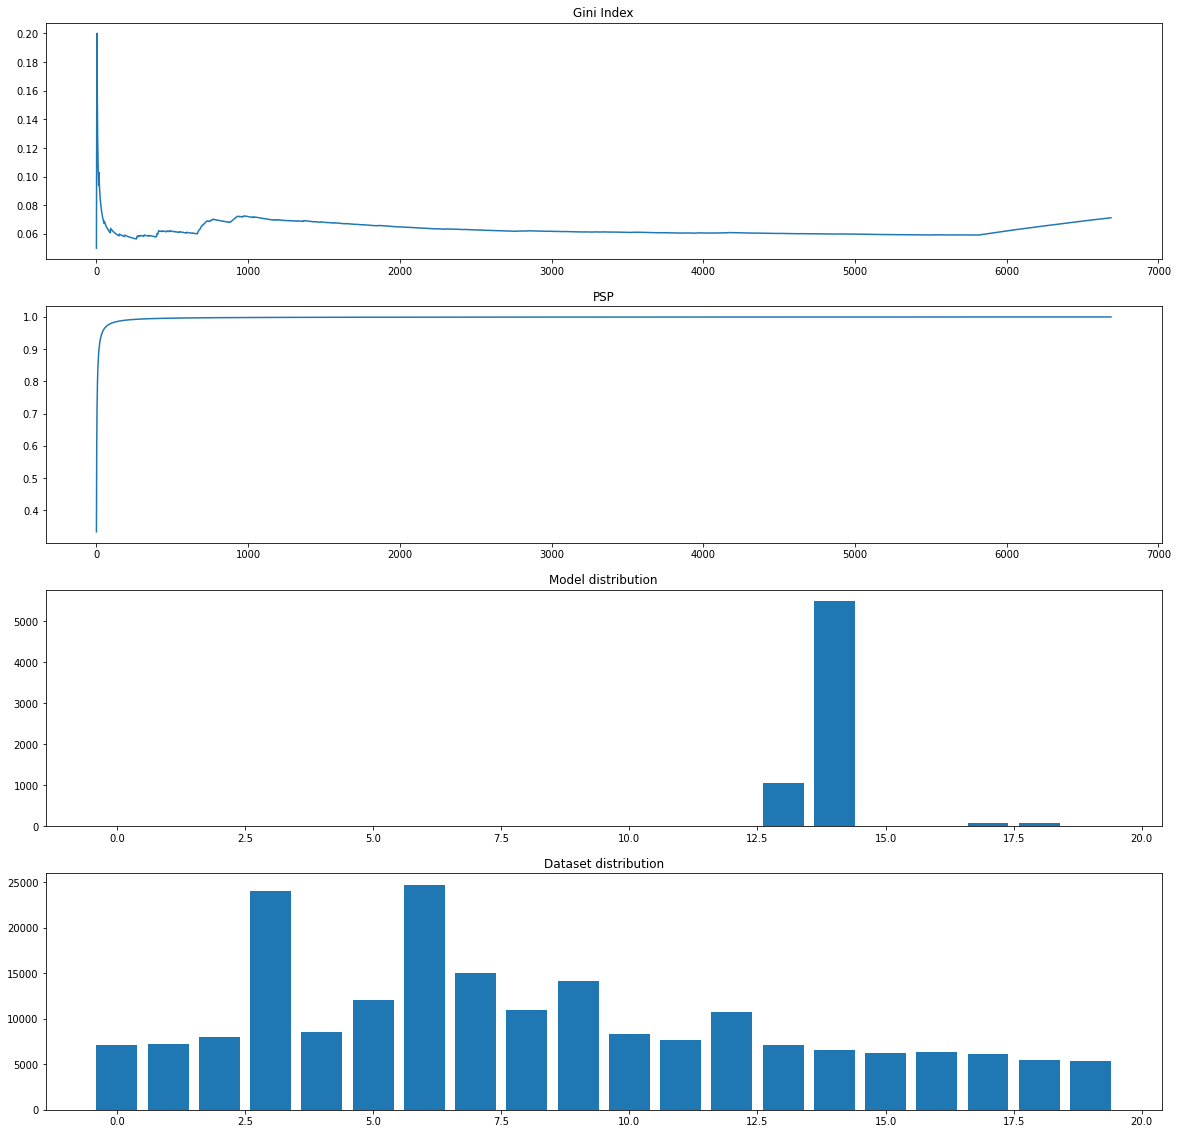

In [ ]:
fairmab = FairEpsGreedy(4, 0.05)
results_EpsGreedy, dist, psp = offlineEvaluate(fairmab, arms, rewards, contexts, None, 0)
evaluateMab(results_EpsGreedy, dist, psp)

201632  total lines
7034  matches
0.23542792152402617  Average reward
0.07122595113532156  Average Gini Index
0.9977435081512142  Average PSP


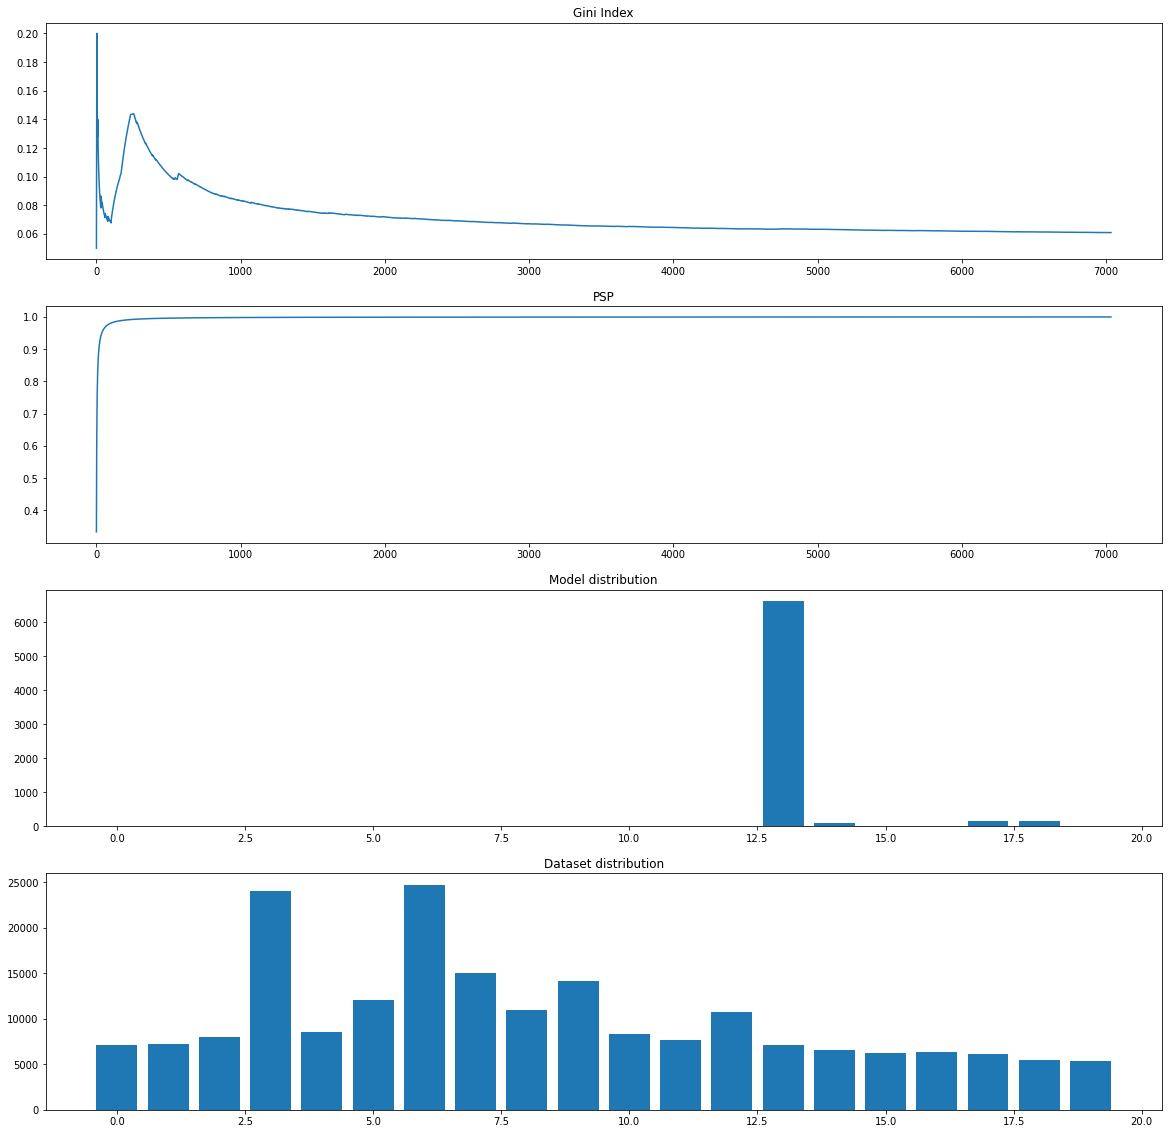

In [ ]:
fairmab = FairEpsGreedy(4, 0.05)
results_EpsGreedy, dist, psp = offlineEvaluate(fairmab, arms, rewards, contexts, None, 1)
evaluateMab(results_EpsGreedy, dist, psp)

201632  total lines
7026  matches
0.23783091374893253  Average reward
0.0634661932825299  Average Gini Index
0.9977412626653809  Average PSP


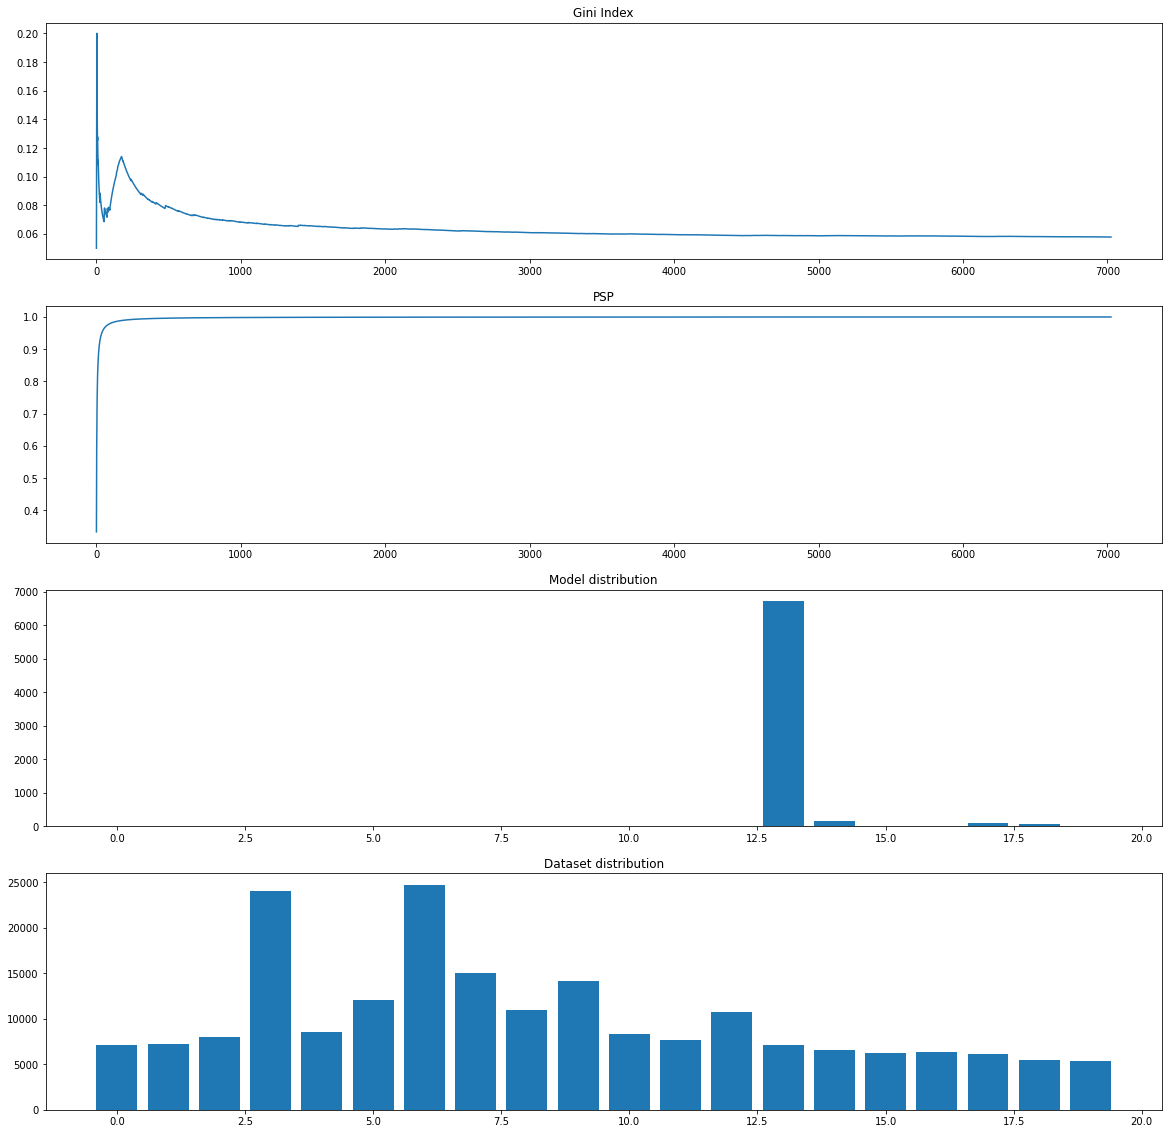

In [ ]:
fairmab = FairEpsGreedy(4, 0.05)
results_EpsGreedy, dist, psp = offlineEvaluate(fairmab, arms, rewards, contexts, None, 2)
evaluateMab(results_EpsGreedy, dist, psp)

In [68]:
class BalancedEpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        if not (epsilon >= 0 and epsilon <= 1):
            raise ValueError("`epsilon` must be a number in [0,1]")
        if not type(epsilon) == float:
            raise TypeError("`epsilon` must be float")
        if not type(Q0) == float:
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.epsilon = epsilon
        self.q = np.full(n_arms, Q0)      # initialise q values
        self.rewards = np.zeros(n_arms)     # keep the total rewards per arm
        self.clicks = np.zeros(n_arms)      # count the pulled rounds per arm
        self.mab = EpsGreedy(20, epsilon)
        self.armtogenre = [13, 14, 17, 18, 19]
        self.genretoarm = {13: 0, 14: 1, 17: 2, 18: 3, 19: 4}
    
    # select a random arm to explore or a arm with best rewards to exploit, then return the arm 
    def play(self, context=None):
        super().play(context)
        if np.random.random_sample() <= self.epsilon:           #explore
            arm = np.random.randint(0,self.n_arms)
        else:
            arm = break_tie(self.q)
        arm = self.armtogenre[arm]
        if arm == 19:
            arm = self.mab.play(context)
        return arm
    
    # update values
    def update(self, arm, reward, context=None):
        if arm not in self.armtogenre:
            self.mab.update(arm, reward, context)
            arm = 4
        else:
            arm = self.genretoarm[arm]  
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm] / self.clicks[arm]
        

201632  total lines
7392  matches
0.29274891774891776  Average reward
0.5121453367504903  Average Gini Index
0.18536334834445833  Average PSP


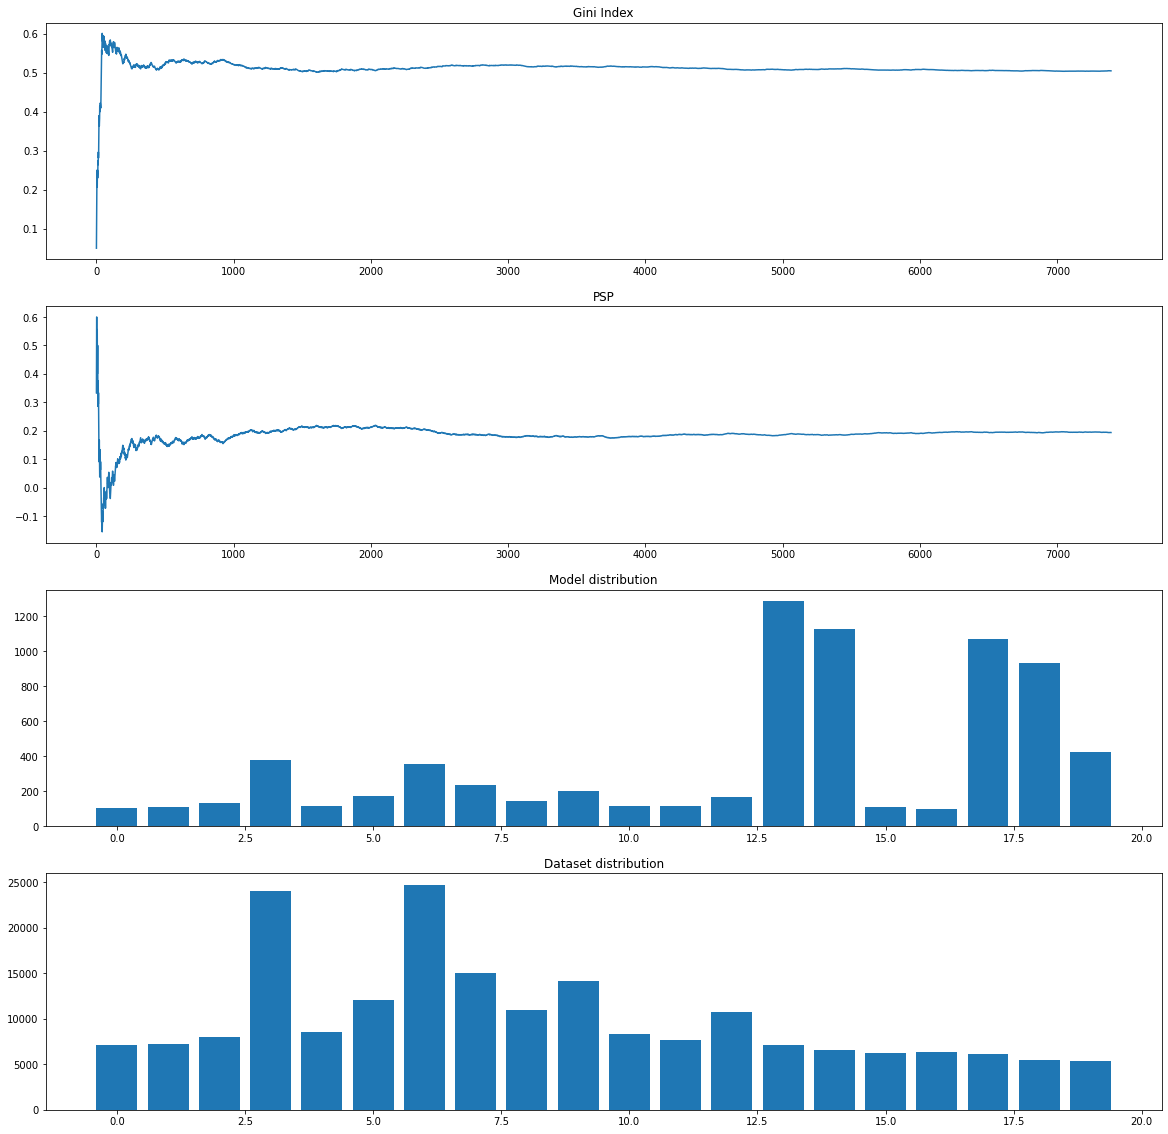

In [70]:
fairmab = BalancedEpsGreedy(5, 0.5)
results_EpsGreedy, dist, psp = offlineEvaluate(fairmab, arms, rewards, contexts, None, 0)
evaluateMab(results_EpsGreedy, dist, psp)

## 2. UCB MAB

In [ ]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        if not rho > 0:
            raise ValueError("`rho` must be positive")
        if not (type(rho) == float and np.isreal(rho)):
            raise TypeError("`rho` must be real float")
        if not type(Q0) == float :
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.rho = rho
        self.q = np.full(n_arms, Q0)
        self.rewards = np.zeros(n_arms)  
        self.avg_rewards = np.zeros(n_arms)
        self.clicks = np.zeros(n_arms)
        self.round = 0        # to count the number of round played
    
    def play(self, context=None):
        super().play(context)
        self.round += 1
        self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)

        arm = break_tie(self.q)
        
        return int(arm)
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += reward
        self.avg_rewards[arm] = self.rewards[arm]/ self.clicks[arm]
        

In [ ]:
# warning control
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

201632  total lines
7272  matches
0.9751100110011001  Average reward
0.1361064971763675  Average Gini Index
-0.9701393461077639  Average PSP


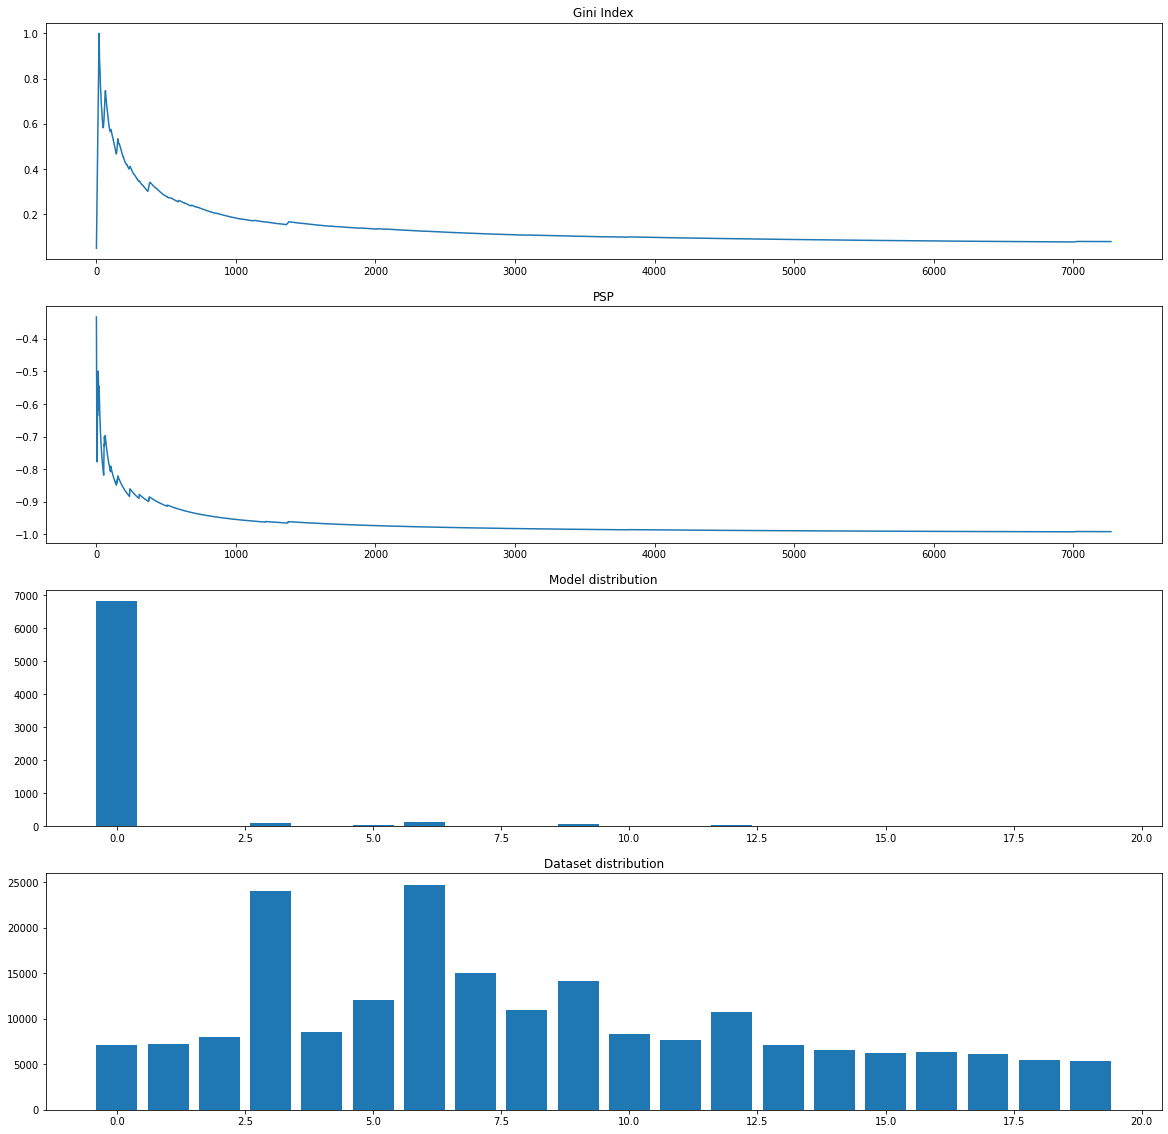

In [ ]:
mab = UCB(20, 1.0)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 0)
evaluateMab(results_EpsGreedy, dist, psp)


201632  total lines
7358  matches
0.95338407175863  Average reward
0.18135606664072035  Average Gini Index
-0.9534918948419986  Average PSP


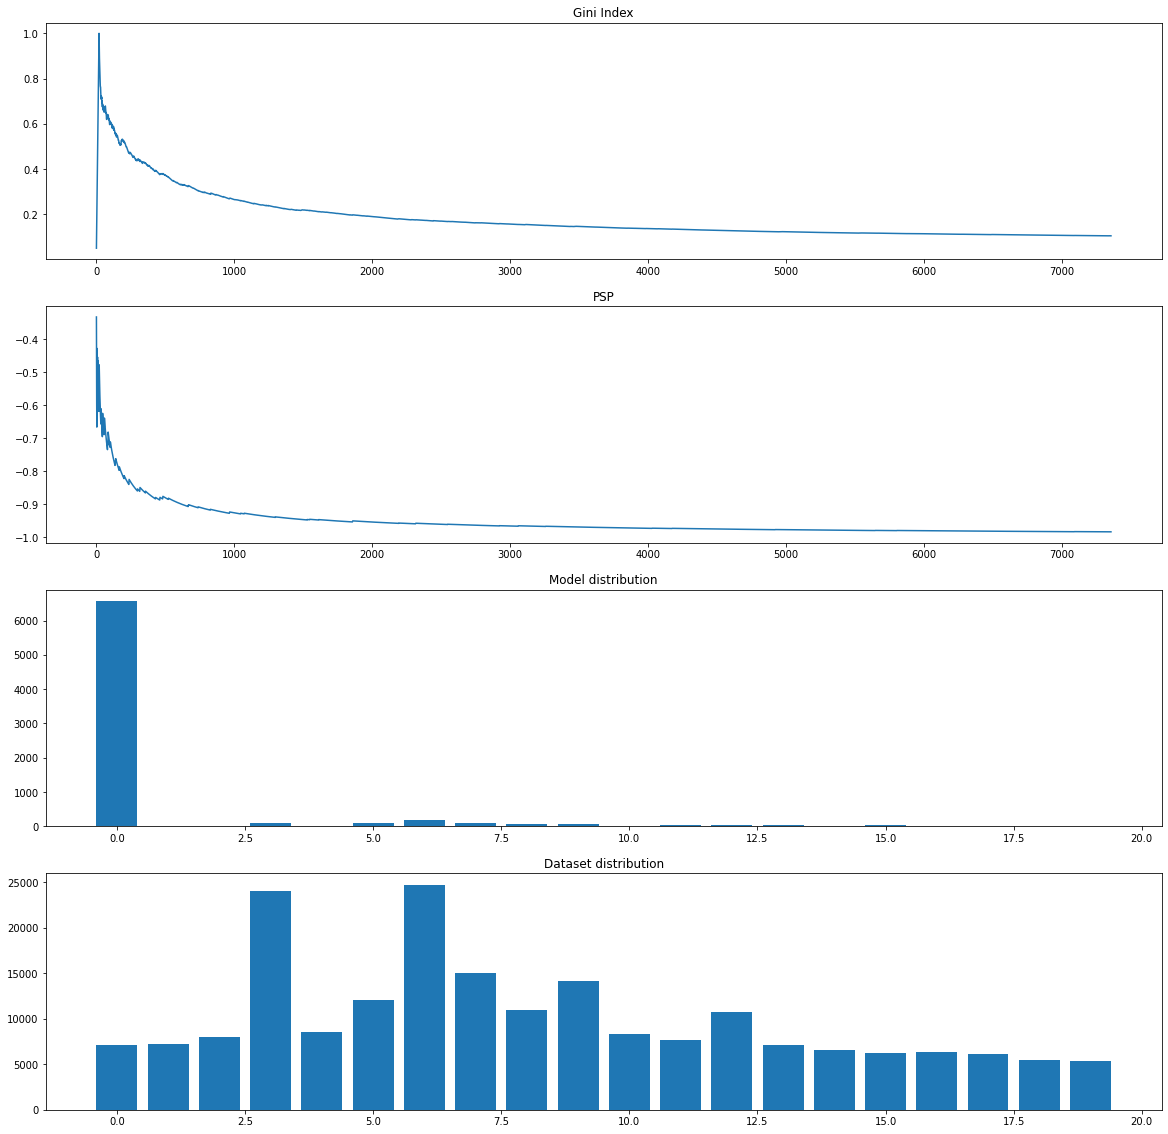

In [ ]:
mab = UCB(20, 1.0)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 1)
evaluateMab(results_EpsGreedy, dist, psp)

201632  total lines
7388  matches
0.9630481862479697  Average reward
0.16859136778627248  Average Gini Index
-0.9649024087874197  Average PSP


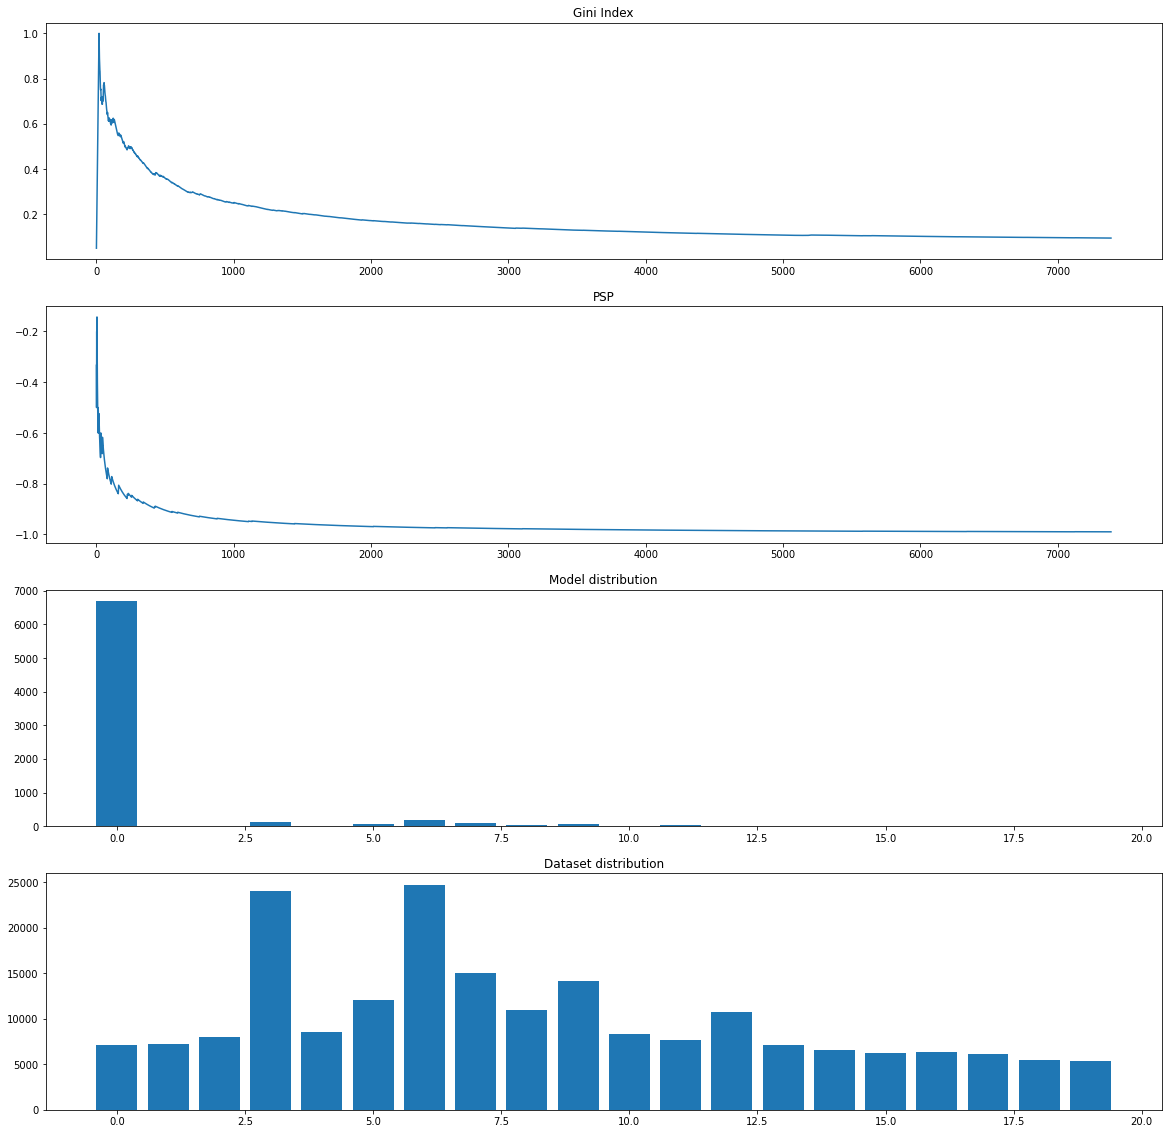

In [ ]:
mab = UCB(20, 1.0)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 2)
evaluateMab(results_EpsGreedy, dist, psp)

In [57]:
class FairUCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        if not rho > 0:
            raise ValueError("`rho` must be positive")
        if not (type(rho) == float and np.isreal(rho)):
            raise TypeError("`rho` must be real float")
        if not type(Q0) == float :
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.rho = rho
        self.q = np.full(n_arms, Q0)
        self.rewards = np.zeros(n_arms)  
        self.avg_rewards = np.zeros(n_arms)
        self.clicks = np.zeros(n_arms)
        self.round = 0        # to count the number of round played
        self.armtogenre = [13, 14, 17, 18]
        self.genretoarm = {13: 0, 14: 1, 17: 2, 18: 3}
    
    def play(self, context=None):
        super().play(context)
        self.round += 1
        self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)

        arm = break_tie(self.q)
        
        return int(self.armtogenre[arm])
        
    def update(self, arm, reward, context=None):
        arm = self.genretoarm[arm]        
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += reward
        self.avg_rewards[arm] = self.rewards[arm]/ self.clicks[arm]
        

201632  total lines
7013  matches
0.2298588335947526  Average reward
0.08879798685068467  Average Gini Index
0.9977376036128385  Average PSP


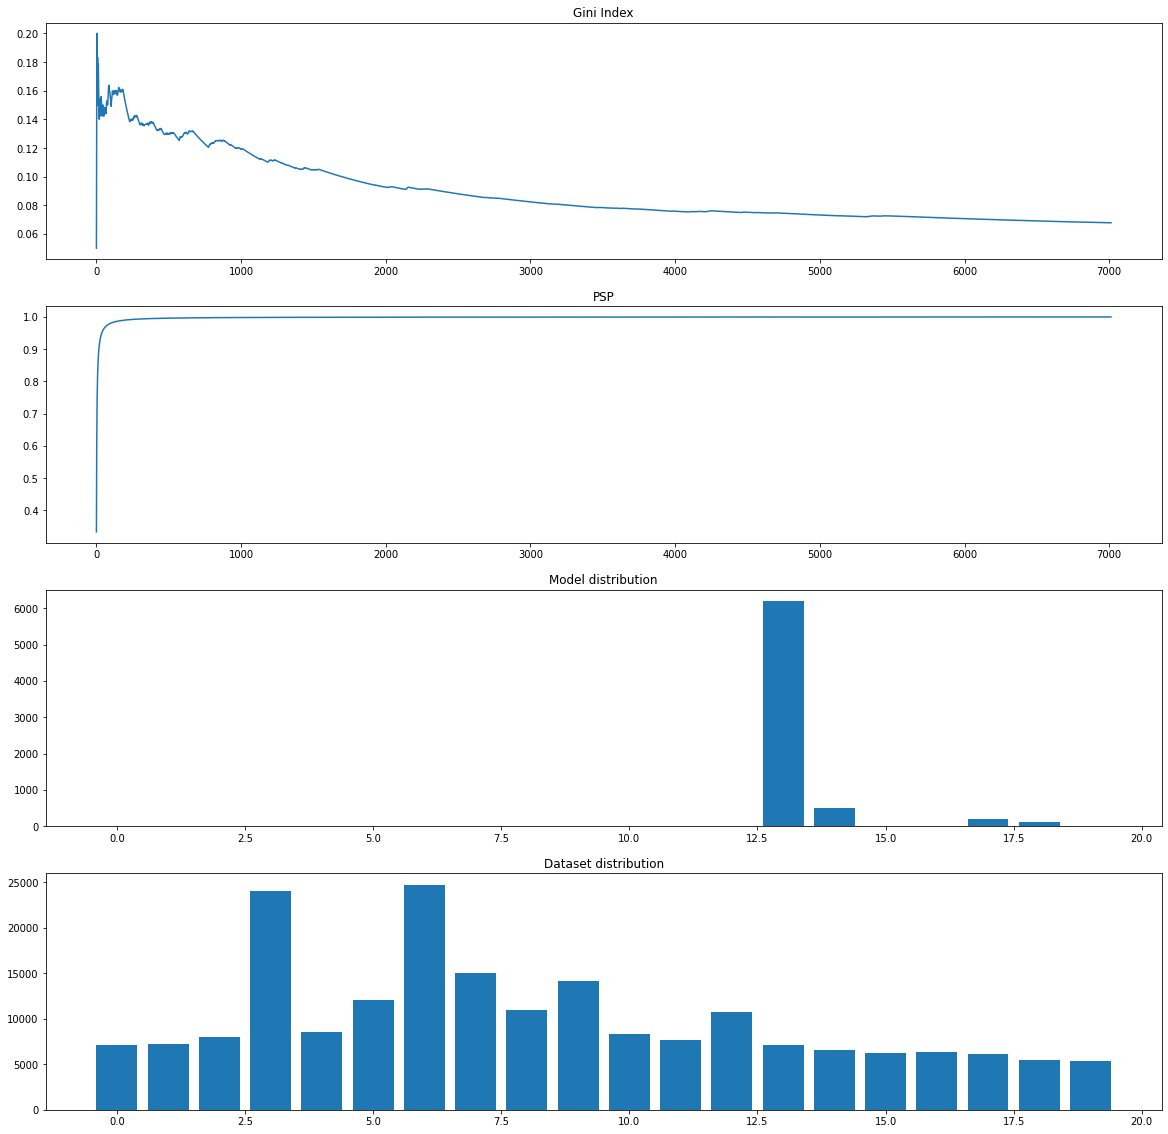

In [60]:
mab = FairUCB(4, 1.0)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None, 0)
evaluateMab(results_EpsGreedy, dist, psp)

## 3. LinUCB contextual MAB

In [ ]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, alpha):
        if not (type(n_dims) == int or n_dims.dtype == 'int64'):
            raise TypeError("`n_dims` must be integer type")
        if not (type(alpha) == float or alpha.dtype == 'float64'):
            raise TypeError("`alpha` must be float")
        if not (alpha > 0.0 and np.isreal(alpha)):
            raise ValueError("`alpha` must be positive real")
        
        super().__init__(n_arms) 
        self.n_dims = n_dims #1
        self.alpha = alpha 
        self.post_dist = np.zeros(n_arms) #1
        '''initialise keys and values; key is arm, A for covariance, inv_A for inverse of A, 
                                        b for reward, theta for coefficient vector''' 
        self.A = np.array(np.identity(n_dims))
        # print("A ", self.A.shape)
        self.inv_A = [np.linalg.inv(self.A)]*n_arms
        # print(np.shape(self.inv_A))
        self.A  = [self.A]*n_arms
        # print(np.shape(self.A))

        self.b = [np.zeros(n_dims)]*n_arms
        # print(np.shape(self.b))
        self.theta = [(np.linalg.inv(np.identity(n_dims)) @  np.zeros(n_dims))]*n_arms
        # print(np.shape(self.theta))
         
    # return the best arm
    def play(self, context):
        super().play(context)
        # calculate posterior distribution of the coefficient vector 
        for arm in range(self.n_arms):
            inv_A = self.inv_A[arm]
            theta = self.theta[arm]

            # calculate posterior distribution of the coefficient vector
            # self.post_dist[arm] = theta @ context[arm] + self.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])
            temp1 = theta @ context[arm]
            temp2 = self.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])
            # print(self.post_dist.shape)
            self.post_dist[arm] = temp1 + temp2
        arm = break_tie(self.post_dist)
        return int(arm)    
    
    # update dictionary
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        reshaped_context = context[arm].reshape(-1,1)   # reshape to the right form
        self.A[arm] = self.A[arm] + reshaped_context @ reshaped_context.T
        self.inv_A[arm] = np.linalg.inv(self.A[arm])
        self.b[arm] = self.b[arm] + reward * context[arm]
        self.theta[arm] = self.inv_A[arm] @ self.b[arm]

201632  total lines
18137  matches
0.8218007388211942  Average reward
0.17278092711929466  Average Gini Index
-0.9811498382104904  Average PSP


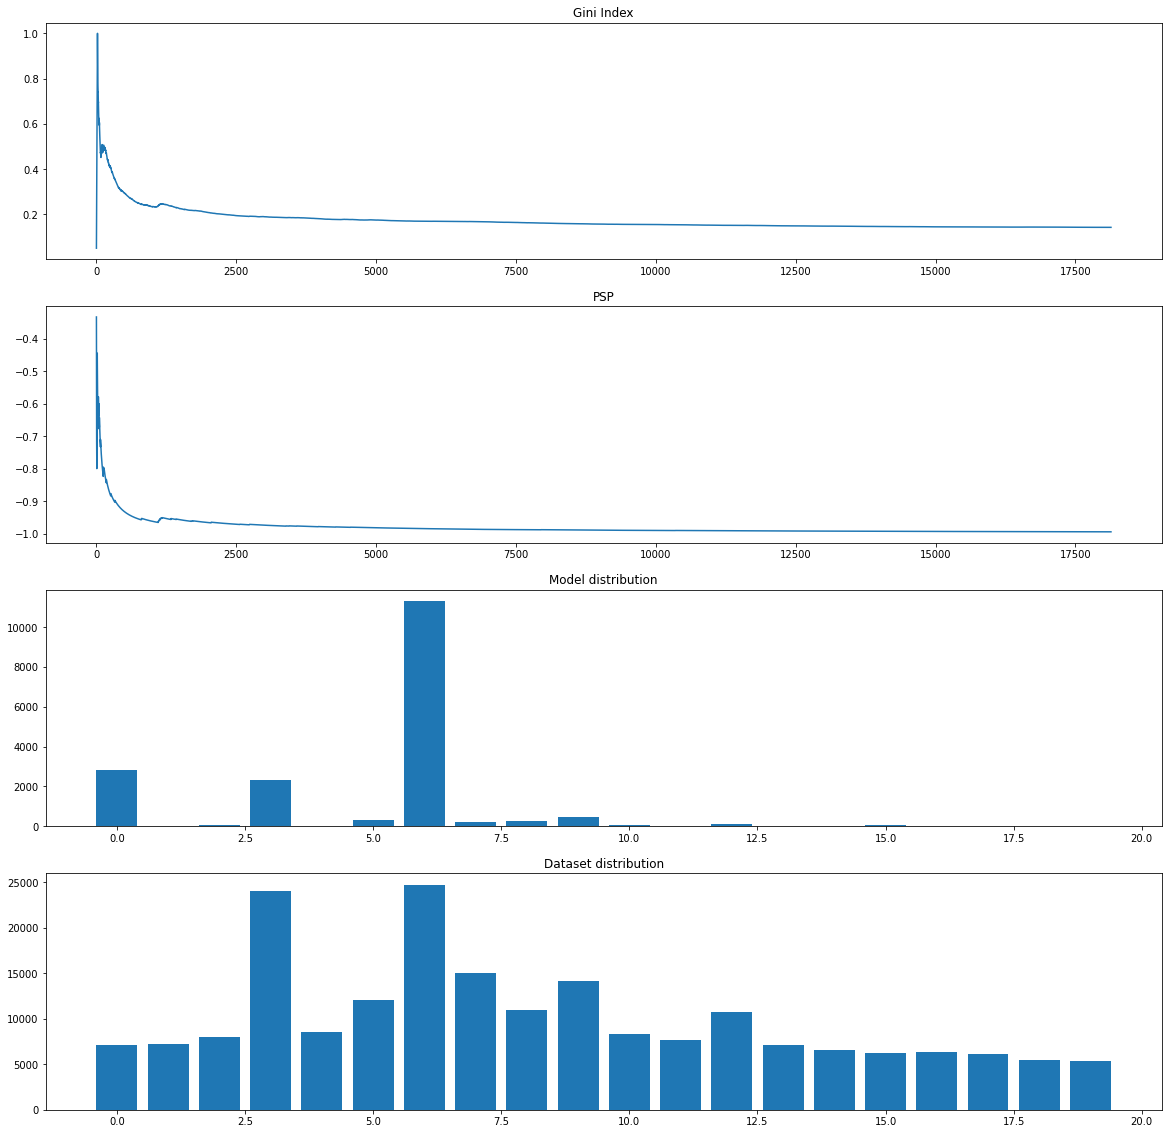

In [55]:
mab = LinUCB(20, 1, 1.0)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts,None)
# print('LinUCB average reward', np.mean(results_LinUCB))
evaluateMab(results_EpsGreedy, dist, psp)

In [61]:
class FairLinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, alpha):
        if not (type(n_dims) == int or n_dims.dtype == 'int64'):
            raise TypeError("`n_dims` must be integer type")
        if not (type(alpha) == float or alpha.dtype == 'float64'):
            raise TypeError("`alpha` must be float")
        if not (alpha > 0.0 and np.isreal(alpha)):
            raise ValueError("`alpha` must be positive real")
        
        super().__init__(n_arms) 
        self.n_dims = n_dims #1
        self.alpha = alpha 
        self.post_dist = np.zeros(n_arms) #1
        '''initialise keys and values; key is arm, A for covariance, inv_A for inverse of A, 
                                        b for reward, theta for coefficient vector''' 
        self.A = np.array(np.identity(n_dims))
        # print("A ", self.A.shape)
        self.inv_A = [np.linalg.inv(self.A)]*n_arms
        # print(np.shape(self.inv_A))
        self.A  = [self.A]*n_arms
        # print(np.shape(self.A))

        self.b = [np.zeros(n_dims)]*n_arms
        # print(np.shape(self.b))
        self.theta = [(np.linalg.inv(np.identity(n_dims)) @  np.zeros(n_dims))]*n_arms
        # print(np.shape(self.theta))
        self.armtogenre = [13, 14, 17, 18, 19]
        self.genretoarm = {13: 0, 14: 1, 17: 2, 18: 3, 19: 4}
         
    # return the best arm
    def play(self, context):
        super().play(context)
        # calculate posterior distribution of the coefficient vector 
        for arm in range(self.n_arms):
            inv_A = self.inv_A[arm]
            theta = self.theta[arm]

            # calculate posterior distribution of the coefficient vector
            # self.post_dist[arm] = theta @ context[arm] + self.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])
            temp1 = theta @ context[arm]
            temp2 = self.alpha * np.sqrt(context[arm].T @ inv_A @ context[arm])
            # print(self.post_dist.shape)
            self.post_dist[arm] = temp1 + temp2
        arm = break_tie(self.post_dist)
        return int(self.armtogenre[arm])    
    
    # update dictionary
    def update(self, arm, reward, context):
        arm = self.genretoarm[arm]
        super().update(arm, reward, context)
        reshaped_context = context[arm].reshape(-1,1)   # reshape to the right form
        self.A[arm] = self.A[arm] + reshaped_context @ reshaped_context.T
        self.inv_A[arm] = np.linalg.inv(self.A[arm])
        self.b[arm] = self.b[arm] + reward * context[arm]
        self.theta[arm] = self.inv_A[arm] @ self.b[arm]

201632  total lines
6642  matches
0.19617585064739537  Average reward
0.13062100382354788  Average Gini Index
0.997627593980844  Average PSP


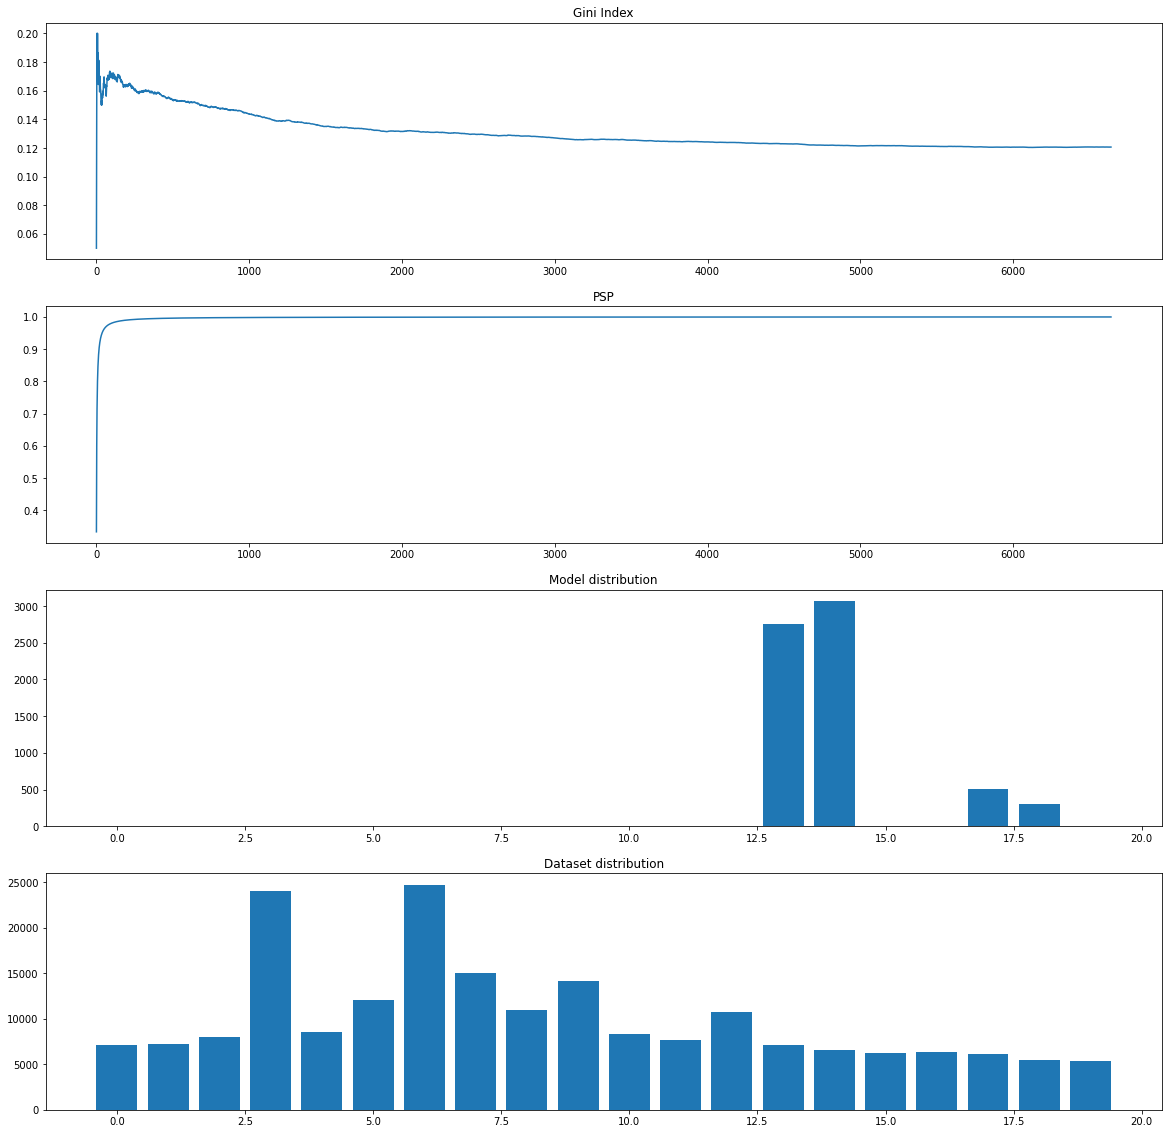

In [62]:
mab = FairLinUCB(4, 1, 1.0)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts,None)
# print('LinUCB average reward', np.mean(results_LinUCB))
evaluateMab(results_EpsGreedy, dist, psp)

## 4. TreeBootstrap contextual MAB

In [ ]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[] for i in range(n_arms) ] 
        self.r = [0 for i in range(n_arms) ]
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        
    # return the best arm 
    def play(self, context):
        super().play(context)
        for arm in range(self.n_arms):
            shaped_context = context[arm].reshape(1, -1)         # reshape the form
            if len(self.D[arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1 
            else:
                sample_context = self.D[arm]
                sample_reward = self.r[arm]      
                tree = self.tree.fit(sample_context, sample_reward)          # train the tree classifier
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context 
                self.prob[arm] = temp_p[0][1]                   # save it
        arm = break_tie(self.prob)
        
        return arm                
    
    # update 
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        if len(self.D[arm]) == 0:
            self.D[arm] = np.vstack((shaped_context, shaped_context))
            self.r[arm] = np.vstack((np.array([0.]),np.array([1.])))     

        self.D[arm] = np.vstack((self.D[arm], shaped_context))
        self.r[arm] = np.vstack((self.r[arm], reward))

            

201632  total lines
800  matches
0.89375  Average reward
0.2201352054860235  Average Gini Index
-0.9426241838782378  Average PSP


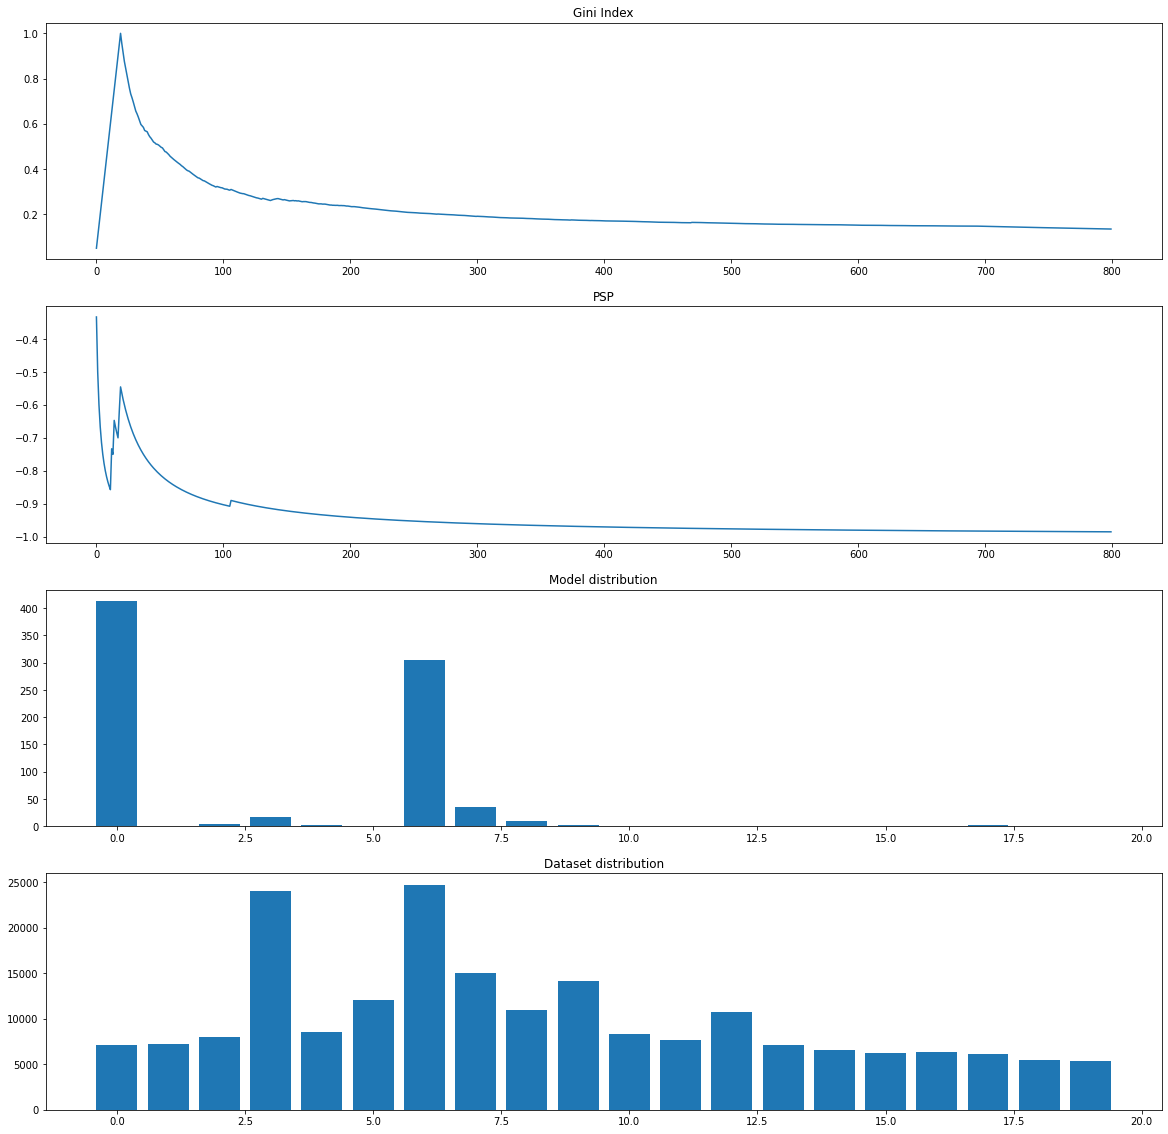

In [ ]:
mab = TreeBootstrap(20, 1)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None) 

evaluateMab(results_EpsGreedy, dist, psp)

In [63]:
class FairTreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        self.n_dims = n_dims
        self.tree = tree
        self.D = [[] for i in range(n_arms) ] 
        self.r = [0 for i in range(n_arms) ]
        self.prob = np.zeros(self.n_arms)  # create zero array to save predicted probability from treeclassifier
        self.armtogenre = [13, 14, 17, 18, 19]
        self.genretoarm = {13: 0, 14: 1, 17: 2, 18: 3, 19: 4}
        
    # return the best arm 
    def play(self, context):
        super().play(context)
        for arm in range(self.n_arms):
            shaped_context = context[arm].reshape(1, -1)         # reshape the form
            if len(self.D[arm]) == 0:
                # set decision tree to predict 1 regardless of the input
                self.prob[arm] = 1.0  # predict 1 
            else:
                sample_context = self.D[arm]
                sample_reward = self.r[arm]      
                tree = self.tree.fit(sample_context, sample_reward)          # train the tree classifier
                temp_p = tree.predict_proba(shaped_context)      # predict the probability of the current context 
                self.prob[arm] = temp_p[0][1]                   # save it
        arm = break_tie(self.prob)
        
        return self.armtogenre[arm]                
    
    # update 
    def update(self, arm, reward, context):
        arm = self.genretoarm[arm]
        super().update(arm, reward, context)
        shaped_context = context[arm].reshape(1, -1)             # reshape the form

        if len(self.D[arm]) == 0:
            self.D[arm] = np.vstack((shaped_context, shaped_context))
            self.r[arm] = np.vstack((np.array([0.]),np.array([1.])))     

        self.D[arm] = np.vstack((self.D[arm], shaped_context))
        self.r[arm] = np.vstack((self.r[arm], reward))

            

201632  total lines
7120  matches
0.22991573033707866  Average reward
0.0974586273958629  Average Gini Index
0.9977673511988499  Average PSP


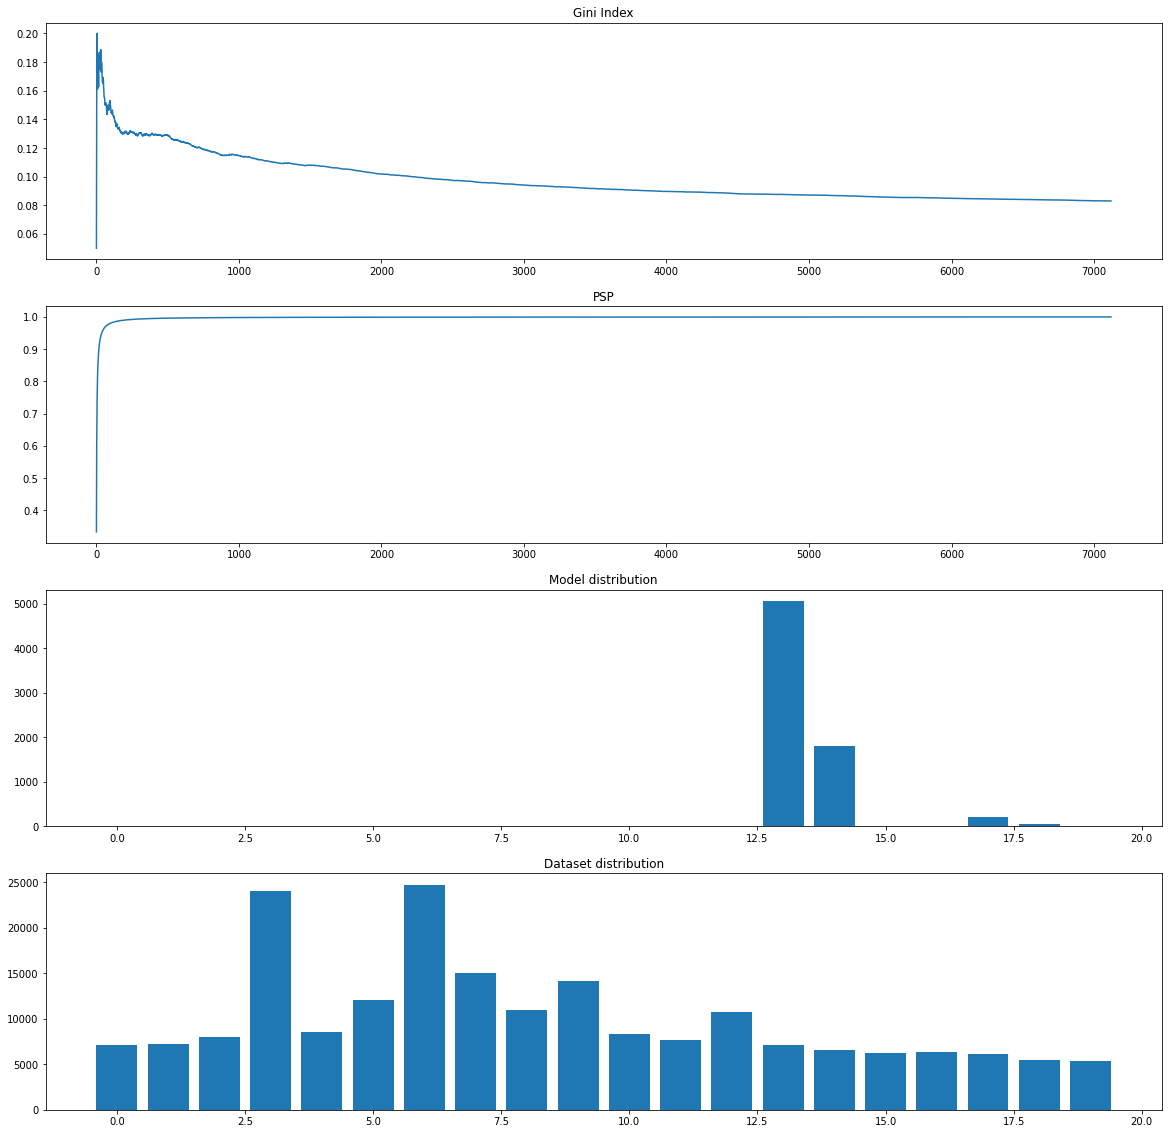

In [65]:
mab = FairTreeBootstrap(4, 1)
results_EpsGreedy, dist, psp = offlineEvaluate(mab, arms, rewards, contexts, None) 

evaluateMab(results_EpsGreedy, dist, psp)

## Evaluation and hyperparameter tuning for LinUCB

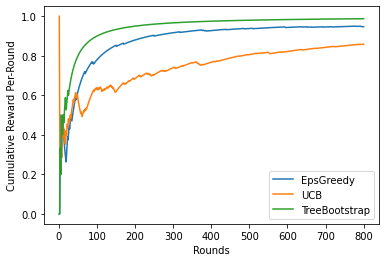

In [ ]:
# plot cumulative reward per round 
eg_results, ucb_results, linucb_results, tbs_results, round_list = [], [], [], [], []  # create lists
n_rounds = 800                                       # the total number of rounds 
eg_sum, ucb_sum,linucb_sum, tbs_sum = 0, 0, 0, 0     # set the initial reward sum

# get the 800 results from the previous run per each algorithm 
for n_round in range(1, n_rounds + 1):              # start from 1 to avoid zero devision error
    eg_sum += results_EpsGreedy[n_round-1]
    ucb_sum += results_UCB[n_round-1]
    #linucb_sum += results_LinUCB[n_round-1] 
    tbs_sum += results_TreeBootstrap[n_round-1]
    eg_results.append(eg_sum/n_round)
    ucb_results.append(ucb_sum/n_round)
    #linucb_results.append(linucb_sum/n_round)
    tbs_results.append(tbs_sum/n_round)
    round_list.append(n_round)

# plot the results
plt.plot(round_list,eg_results, label = "EpsGreedy")
plt.plot(round_list,ucb_results, label = "UCB")
#plt.plot(round_list,linucb_results, label = "LinUCB")
plt.plot(round_list,tbs_results, label = "TreeBootstrap")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()

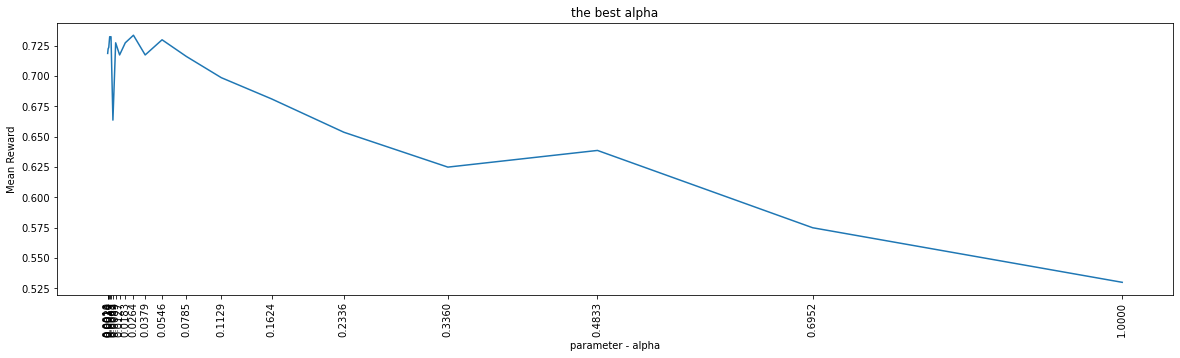

The best alpha for LinUCB is 0.026 with reward 0.73375


In [ ]:
# hyperparameter optimization
alpha_list = np.logspace(-3,0,num= 20)    # generate valid alpha values
n_rounds = 800                            # set the initial number of round
max_reward = -np.inf                      # set the initial max reward
best_alpha = None                         # set the initial best alpha
results = []

# run with a set of alpha
for alpha in alpha_list:
    grid_mab = LinUCB(10, 10, alpha)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    results.append(temp_result)
    if temp_result > max_reward:  # get the maximum mean rewards with the best alpha
        best_alpha = alpha
        max_reward = temp_result


# show the plot
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(alpha_list,results)
plt.xticks(alpha_list, rotation = 'vertical')
plt.title('the best alpha')
plt.ylabel('Mean Reward')
plt.xlabel('parameter - alpha')
plt.show()
print("The best alpha for LinUCB is", round(best_alpha, 3), "with reward", max_reward)

#The best alpha for LinUCB is 0.026 with reward 0.73375

## 6. Implement KernelUCB contextual MAB

In [ ]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    # initialise values and raise input errors
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        if not type(n_dims) == int :
            raise TypeError("`n_dims` must be integer type")
        if not (type(gamma) == float  or gamma.dtype == 'float64'):
            raise TypeError("`gamma` must be float type")
        if not np.isreal(gamma):
            raise ValueError("`gamma` must be a real number")
        if not (type(eta) == float  or eta.dtype == 'float64'):
            raise TypeError("`eta` must be float type")    
        if not np.isreal(eta):
            raise ValueError("`eta` must be a real number")
            
        self.n_dims = n_dims                # the number of dimension
        self.gamma = gamma                  # regularization parameter
        self.eta  = eta                     # exploration parameter
        self.kern = kern                    # kernel function
        self.inv_K = None                   # inversed kernel matrices
        self.u = np.zeros(self.n_arms)      # upper bounds of probability
        self.y = np.empty(0)                # reward history
        self.pre_x = np.empty(0)            # collect the previous contexts(x) for b
        self.n_round = 0                    # count the number of round 
    
    # return the arm with the highest upper bounds of rewards
    def play(self, context):
        super().play(context)
        if self.n_round == 0:               # set the initial upper bound reward
            self.u[0] = 1.0
        else:
            k = self.kern(context, self.pre_x)         # calculate all kernel fn for previous contexts
            for arm in range(self.n_arms):
                shaped_context = context[arm].reshape(1, -1)
                sigma = np.sqrt(self.kern(shaped_context, shaped_context) - k[arm] @ self.inv_K  @ k[arm])   # calculate width (sigma)
                self.u[arm] = k[arm] @ self.inv_K @ self.y + (self.eta / np.sqrt(self.gamma)) * sigma        # calculate upper bound

        arm = break_tie(self.u)
        return arm
       
    def update(self, arm, reward, context):
        shaped_context = context[arm].reshape(1, -1)            # reshape context
        shaped_reward = np.array(reward).reshape(1, -1)         # reshape reward
   
        if self.n_round == 0:                                   # set the first values 
            self.y = shaped_reward
            self.pre_x = shaped_context
            self.K = self.kern(shaped_context, shaped_context) + self.gamma
            self.inv_K  = 1 / (self.K)                        
            
        else:
            self.y = np.r_[self.y, shaped_reward]               # update reward
            k = self.kern(context, self.pre_x)                  # calculate k (xa,t)
            b = k[arm].reshape(self.n_round, 1)
        
            bT_invK = b.T @ self.inv_K                          # previously calculate expensive calculation
            invK_b = self.inv_K  @ b
            K22 = np.linalg.inv(self.kern(shaped_context, shaped_context) + self.gamma - bT_invK @ b) 
            K11 = self.inv_K + K22 * invK_b @ bT_invK
            K12 = - K22 * invK_b
            K21 = - K22 * bT_invK
            
            self.pre_x = np.r_[self.pre_x, shaped_context]      # update previous context
            self.inv_K = np.vstack((np.hstack((K11, K12)), np.hstack((K21, K22))))    # update inverse K value
            
        self.n_round += 1
            
        

In [ ]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

KernelUCB average reward 0.67875


In [ ]:
# hyperparameter optimization
gamma_list = np.linspace(0, 1, num = 11)[1:]       # generate valid gamma values & remove 0.0
eta_list = np.linspace(0, 0.5, num = 11)[1:]       # generate valid eta values & remove 0.0
n_rounds = 800                                     # set the initial number of round
gam_max_reward, eta_max_reward = -np.inf, -np.inf  # set the initial max reward for gamma and eta

# get the maximum mean rewards with the the initial eta
eta = 0.1
for gam in gamma_list:
    grid_mab = KernelUCB(10, 10, gam, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > gam_max_reward:      # get the maximum mean rewards with the best eta and gamma
        gam_max_reward = temp_result  
        best_gamma = gam

print("The best gamma for Kernel UCB is {", round(best_gamma, 3), "} with reward", gam_max_reward)

for eta in eta_list:
    grid_mab = KernelUCB(10, 10, best_gamma, eta, rbf_kernel)
    temp_result = offlineEvaluate(grid_mab, arms, rewards, contexts, n_rounds)
    temp_result = np.mean(temp_result)
    if temp_result > eta_max_reward:   # get the maximum mean rewards with the best gamma
        eta_max_reward = temp_result
        best_eta =  eta
        
print("The best eta for Kernel UCB is {", round(best_eta, 3), "} with reward", eta_max_reward)


The best gamma for Kernel UCB is { 0.5 } with reward 0.77625
The best eta for Kernel UCB is { 0.25 } with reward 0.79125


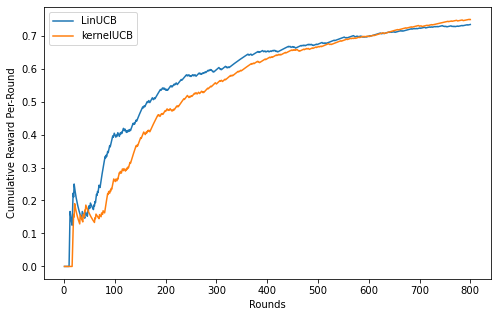

In [ ]:
# your plotting code here LinUCB vs Kernel UCB
best_lin_results, best_ker_results, round_list = [], [], []        # create lists for results
n_rounds = 800                                                     # the total number of rounds 
best_lin_sum, best_ker_sum = 0, 0                                  # set the initial reward sum

best_lin_mab = LinUCB(10, 10, best_alpha)
best_results_LinUCB = offlineEvaluate(best_lin_mab, arms, rewards, contexts,800)

# run UCB algorithms
best_kernel_mab = KernelUCB(10, 10, best_gamma, best_eta , rbf_kernel)
best_results_KernelUCB = offlineEvaluate(best_kernel_mab, arms, rewards, contexts, 800)

for n_round in range(1, n_rounds + 1):
    best_lin_sum += best_results_LinUCB[n_round-1] 
    best_ker_sum += best_results_KernelUCB[n_round-1]
    
    # append ccumulative rewards
    best_lin_results.append(best_lin_sum/n_round)
    best_ker_results.append(best_ker_sum/n_round)
    round_list.append(n_round)

# plot 
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(round_list, best_lin_results, label = "LinUCB")
plt.plot(round_list, best_ker_results, label = "kernelUCB")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()